In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.covfunc import squaredExponential
from pyGPGO.acquisition import Acquisition
from pyGPGO.GPGO import GPGO
from rdkit import Chem
import csv
import itertools as it
import numpy as np
import networkx as nx

import logging
logger = logging.getLogger()
logger.disabled = True

%matplotlib inline

Extract molecular fingerprints from molecular structures. The code is taken from [here](https://github.com/neltnerb/machine-learning/blob/master/solubility/solubility_estimator.py).

In [2]:
# First I need to import the raw data from the csv file.
#
# Note, I modified the original solubility.txt file to manually replace
# commas in compound names with semicolons so that the extractor doesn't
# confuse them for delimiters. I simultaneously parse the SMILES string
# into a rdkit molecule object for easier feature extraction.

y_data = []
SMILES_data = []
mol_data = []

# atom_data will contain a list of example molecules, with each member
# list indexed by the atom index and then with a number representing
# the atomic number of that atom.

# ifile = open('solubility.txt', "r")
ifile = open('solubility.csv', 'r')
reader = csv.reader(ifile, delimiter=',')

# This is the best way I could find to skip the first iterator. The
# method using islice requires that you know how many elements are in
# the iterator, which is definitely more complex than just using a
# flag.

isheader = True
maxAtoms = 0

for row in reader:
    if isheader:
        isheader = False
    else:
        y_data.append(float(row[1]))
        SMILES_data.append(row[3])
        molecule = Chem.MolFromSmiles(row[3])
        numAtoms = molecule.GetNumAtoms()
        if numAtoms > maxAtoms:
            maxAtoms = numAtoms
        mol_data.append(molecule)
        
# Manually set maxAtoms to help get the TensorFlow code right.
maxAtoms = 60
        
# Create numpy array for atom descriptors. Size is [n, i, m] where n
# is the number of examples, i is the max number of atoms in a molecule
# seen while parsing the data, and m is 11 to represent H, C, N, O, F,
# P, S, Cl, Br, I, or metal.

atom_data = np.zeros((len(mol_data), maxAtoms, 11), dtype = float)

# Create numpy array for bond descriptors. Size is [n, i, i, m] where n
# is the number of examples, i is the max number of atoms in a molecule,
# and m is 4 to represent single, double, triple, and aromatic bonds.

bond_data = np.zeros((len(mol_data), maxAtoms, maxAtoms, 4), dtype = float)

# Create numpy array for graph distance. Size is [n, i, i, 7] where n
# is the number of examples, i is the max number of atoms in a molecule,
# and m is 7 where the boolean array contains True if the distance from
# the first atom to the second is less than the bin index. So,
# [0, 0, 1, 3] means whether in training example 0, atoms 0 and 1 are
# closer than 3 bonds away at the shortest distance. These will be
# calculated by building an adjacency matrix from the bond_data array
# and using networkx to convert that to a graph representation which
# is easier to extract the shortest path lengths from.

example_index = 0
distance_data = np.zeros((len(mol_data), maxAtoms, maxAtoms, 7), dtype = float)
graph_data = []

for molecule in mol_data:
    for atom in molecule.GetAtoms():
        atomicNum = atom.GetAtomicNum()
        if atomicNum == 1:
            atom_data[example_index,atom.GetIdx(),0] = 1
        elif atomicNum == 6:
            atom_data[example_index,atom.GetIdx(),1] = 1
        elif atomicNum == 7:
            atom_data[example_index,atom.GetIdx(),2] = 1
        elif atomicNum == 8:
            atom_data[example_index,atom.GetIdx(),3] = 1
        elif atomicNum == 9:
            atom_data[example_index,atom.GetIdx(),4] = 1
        elif atomicNum == 15:
            atom_data[example_index,atom.GetIdx(),5] = 1
        elif atomicNum == 16:
            atom_data[example_index,atom.GetIdx(),6] = 1
        elif atomicNum == 17:
            atom_data[example_index,atom.GetIdx(),7] = 1
        elif atomicNum == 35:
            atom_data[example_index,atom.GetIdx(),8] = 1
        elif atomicNum == 53:
            atom_data[example_index,atom.GetIdx(),9] = 1
        else:
            atom_data[example_index,atom.GetIdx(),10] = 1
    adjacency = np.zeros((molecule.GetNumAtoms(), molecule.GetNumAtoms()), dtype = int)
    for bond in molecule.GetBonds():
        atom1 = bond.GetBeginAtomIdx()
        atom2 = bond.GetEndAtomIdx()
        bondtype = bond.GetBondTypeAsDouble()
        if bondtype == 1:
            bond_data[example_index,atom1,atom2,0] = 1
            bond_data[example_index,atom2,atom1,0] = 1
        elif bondtype == 1.5:
            bond_data[example_index,atom1,atom2,3] = 1
            bond_data[example_index,atom2,atom1,3] = 1
        elif bondtype == 2:
            bond_data[example_index,atom1,atom2,1] = 1
            bond_data[example_index,atom2,atom1,1] = 1
        elif bondtype == 3:
            bond_data[example_index,atom1,atom2,2] = 1
            bond_data[example_index,atom2,atom1,2] = 1
    for atom1 in range(0, molecule.GetNumAtoms()):
        for atom2 in range(atom1+1, molecule.GetNumAtoms()):
            if any(bond_data[example_index,atom1,atom2]):
                adjacency[atom1,atom2] = 1
                adjacency[atom2,atom1] = 1
    graph = nx.from_numpy_matrix(adjacency)
    graph_data.append(graph)
    for atom1 in range(0, molecule.GetNumAtoms()):
        lengths = nx.single_source_shortest_path_length(graph, atom1)
        for atom2 in range(atom1, molecule.GetNumAtoms()):
            distance = lengths[atom2]
            for threshold in range(0,7):
                if distance <= threshold:
                    distance_data[example_index,atom1,atom2,threshold] = 1
                    distance_data[example_index,atom2,atom1,threshold] = 1
    example_index += 1

## Prepare training, validation and test dataset

In [4]:
atom = atom_data.reshape(-1, 60 * 11)
bond = bond_data.reshape(-1, 60*60*4)
distance = distance_data.reshape(-1, 60*60*7)

seed = 17
X_train, X_left, y_train, y_left = train_test_split(X, y, test_size=0.2, random_state=seed)
X_test, X_valid, y_test, y_valid = train_test_split(X_left, y_left, test_size=0.5, random_state=seed)

## Define utility functions

In [15]:
def evaluate(estimator):
    estimator.fit(X_train, y_train)
    score = np.sqrt(mean_squared_error(y_valid, estimator.predict(X_valid)))
    return score

## Random Forests

In [38]:
rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [39]:
evaluate(rf)

1.1305477747090538

In [40]:
rf.fit(X_train, y_train)
np.sqrt(mean_squared_error(rf.predict(X_test), y_test))

1.131833552541309

**Random Forests generates good results (comparable to the paper).**

## Gradient boosted trees

In [49]:
gbr = GradientBoostingRegressor()

### Hyperparameter tuning with Bayesian optimization (PyGPGO)

In [52]:
gbr_params = {'learning_rate':      ('cont', (-5, 0)),
          'n_estimators':  ('int', (50, 500))
         }

def eval_gbr(learning_rate, n_estimators):
    clf = gbr.set_params(learning_rate=10**learning_rate, n_estimators=int(n_estimators))
    return -evaluate(clf)

In [75]:
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.covfunc import squaredExponential
from pyGPGO.acquisition import Acquisition
from pyGPGO.GPGO import GPGO
sexp = squaredExponential()
gp = GaussianProcess(sexp)
acq = Acquisition(mode = 'ExpectedImprovement')
gpgo_gbr = GPGO(gp, acq, eval_gbr, gbr_params, n_jobs=-1)
gpgo_gbr.run(max_iter = 40)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [  -1.02681309  302.        ]. 	  -1.0908760712665024 	 -1.026299074007503
init   	 [  -3.60575981  419.        ]. 	  -2.041498380266327 	 -1.026299074007503
init   	 [  -0.66670846  268.        ]. 	  -1.026299074007503 	 -1.026299074007503
1      	 [  -4.11347466  151.        ]. 	  -2.11711373856 	 -1.02629907401
2      	 [ -1.50643605  89.        ]. 	  -1.33186075757 	 -1.02629907401
3      	 [  -4.63719516  109.        ]. 	  -2.12503292718 	 -1.02629907401
4      	 [  -0.27342495  185.        ]. 	  -1.12679593675 	 -1.02629907401
5      	 [  -1.53887498  464.        ]. 	  -1.10205415249 	 -1.02629907401
6      	 [  -0.39078356  123.        ]. 	  -1.17337506687 	 -1.02629907401
7      	 [  -1.32036332  254.        ]. 	  -1.10215555834 	 -1.02629907401
8      	 [  -1.21520679  314.        ]. 	  -1.084931977 	 -1.02629907401
9      	 [ -1.55931289e-01   4.84000000e+02]. 	  -1.20932947087 	 -1.02629907401
10     	 [  -4.

In [76]:
gbr_opt = gpgo_gbr.getResult()[0]
gbr_opt

OrderedDict([('learning_rate', -0.66670845832218362), ('n_estimators', 268.0)])

In [79]:
gbr_o = gbr.set_params(learning_rate=10**gbr_opt['learning_rate'],
                         n_estimators=int(gbr_opt['n_estimators']))

In [80]:
evaluate(gbr_o)

1.0223616121352406

In [82]:
gbr_o.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.21542273812490345, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=268,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [83]:
np.sqrt(mean_squared_error(y_test, gbr_o.predict(X_test)))

0.97811370644900064

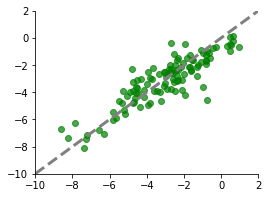

In [84]:
plt.figure(figsize=(4,3))
plt.scatter(y_test, gbr_o.predict(X_test), alpha=0.7, c='green')
plt.plot([-10, 2], [-10, 2], c='grey', ls='--', lw=3)
plt.xlim([-10, 2])
plt.ylim([-10, 2])
sns.despine()

## XGBoost

In [11]:
xgb = XGBRegressor(seed = 0, learning_rate = 0.1, max_depth=4, n_estimators = 600, n_jobs=-1)

In [55]:
def eval_xgb(learning_rate, n_estimators, max_depth):
    clf = xgb.set_params(learning_rate=10**learning_rate, n_estimators=int(n_estimators), max_depth=int(max_depth))
    return -evaluate(clf)

xgb_params = {'learning_rate':      ('cont', (-5, 0)),
              'n_estimators':  ('int', (50, 500)),
              'max_depth': ('int', (2, 10))
         }

sexp = squaredExponential()
gp = GaussianProcess(sexp)
acq = Acquisition(mode = 'ExpectedImprovement')
gpgo_xgb = GPGO(gp, acq, eval_xgb, xgb_params, n_jobs=-1)
gpgo_xgb.run(max_iter = 40)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [  -1.45617814  489.            5.        ]. 	  -0.9636968869137 	 -0.9636968869137
init   	 [  -2.72667081  411.            7.        ]. 	  -2.172088637809196 	 -0.9636968869137
init   	 [  -1.94313329  380.            6.        ]. 	  -1.0234925644851565 	 -0.9636968869137
1      	 [  -0.80991781  104.            4.        ]. 	  -1.00460013391 	 -0.963696886914
2      	 [  -3.20000897  115.            7.        ]. 	  -3.85437350826 	 -0.963696886914
3      	 [ -3.64275463e-01   4.33000000e+02   6.00000000e+00]. 	  -1.08190055175 	 -0.963696886914
4      	 [ -0.59743227  62.           4.        ]. 	  -1.02680198763 	 -0.963696886914
5      	 [ -8.54486523e-02   1.61000000e+02   5.00000000e+00]. 	  -1.17484200547 	 -0.963696886914
6      	 [  -3.1784457  261.           3.       ]. 	  -3.54298891539 	 -0.963696886914
7      	 [  -0.91747698  244.            4.        ]. 	  -0.986479764345 	 -0.963696886914
8      	 [  -0.

### Use best parameters for xgboost

In [56]:
xgb_opt = gpgo_xgb.getResult()[0]
xgb_opt

OrderedDict([('learning_rate', -0.63829050057870695),
             ('n_estimators', 443.0),
             ('max_depth', 4.0)])

In [57]:
xgb_o = xgb.set_params(learning_rate=10**xgb_opt['learning_rate'],
                         n_estimators=int(xgb_opt['n_estimators']),
                         max_depth=int(xgb_opt['max_depth']))

In [58]:
evaluate(xgb_o)

0.95314066203212888

In [59]:
xgb_o.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.22999028924314502,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=443, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

In [60]:
np.sqrt(mean_squared_error(y_test, xgb_o.predict(X_test)))

0.93337742223970421

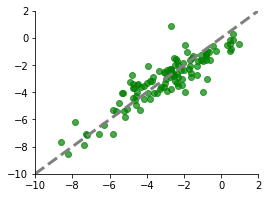

In [61]:
plt.figure(figsize=(4,3))
plt.scatter(y_test, xgb_o.predict(X_test), alpha=0.7, c='green')
plt.plot([-10, 2], [-10, 2], c='grey', ls='--', lw=3)
plt.xlim([-10, 2])
plt.ylim([-10, 2])
sns.despine()

## Lightgbm

In [62]:
def eval_lgb(learning_rate, n_estimators, max_depth):
    clf = LGBMRegressor(learning_rate=10**learning_rate, n_estimators=int(n_estimators), max_depth=int(max_depth), n_jobs=-1)
    return -evaluate(clf)

lgb_params = {'learning_rate':      ('cont', (-5, 0)),
              'n_estimators':  ('int', (500, 3000)),
              'max_depth': ('int', (2, 10))
         }

sexp = squaredExponential()
gp = GaussianProcess(sexp)
acq = Acquisition(mode = 'ExpectedImprovement')
gpgo_lgb = GPGO(gp, acq, eval_lgb, lgb_params, n_jobs=4)
gpgo_lgb.run(max_iter = 40)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ -3.99823943e+00   2.43200000e+03   2.00000000e+00]. 	  -1.9519670145303065 	 -1.025275901191006
init   	 [   -2.49465089  1710.             4.        ]. 	  -1.1322014361148527 	 -1.025275901191006
init   	 [  -1.07968252  816.            3.        ]. 	  -1.025275901191006 	 -1.025275901191006
1      	 [ -3.78237999e+00   2.16500000e+03   2.00000000e+00]. 	  -1.88506728928 	 -1.02527590119
2      	 [   -2.20770102  1487.             9.        ]. 	  -0.941338055695 	 -0.941338055695
3      	 [   -4.29659846  2992.             7.        ]. 	  -1.95267245495 	 -0.941338055695
4      	 [   -3.41299008  1048.             8.        ]. 	  -1.72739050002 	 -0.941338055695
5      	 [   -3.87313904  2013.             3.        ]. 	  -1.91615485527 	 -0.941338055695
6      	 [   -4.63535899  2046.             4.        ]. 	  -2.08139520785 	 -0.941338055695
7      	 [   -4.66937385  1272.             8.        ]. 	  -2.0925176470

In [64]:
lgb_opt = gpgo_lgb.getResult()[0]
lgb_opt

OrderedDict([('learning_rate', -1.7444903727855503),
             ('n_estimators', 2941.0),
             ('max_depth', 9.0)])

In [65]:
lgb = LGBMRegressor(n_estimators=int(lgb_opt['n_estimators']), 
                   n_jobs=-1, 
                   learning_rate=10**lgb_opt['learning_rate'],
                   max_depth=int(lgb_opt['max_depth']))
lgb

LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0,
       learning_rate=0.018009830572561902, max_bin=255, max_depth=9,
       min_child_samples=10, min_child_weight=5, min_split_gain=0.0,
       n_estimators=2941, n_jobs=-1, num_leaves=31, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=50000, subsample_freq=1)

In [66]:
evaluate(lgb)

0.89071174048446022

In [67]:
lgb.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, lgb.predict(X_test)))

0.91946261588767153

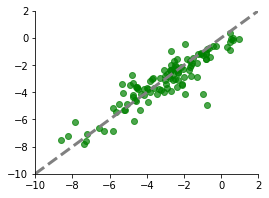

In [68]:
plt.figure(figsize=(4,3))
plt.scatter(y_test, lgb.predict(X_test), alpha=0.7, c='green')
plt.plot([-10, 2], [-10, 2], c='grey', ls='--', lw=3)
plt.xlim([-10, 2])
plt.ylim([-10, 2])
sns.despine()

## Model improvement by stacking

In [69]:
from mlxtend.regressor import StackingCVRegressor
stack = StackingCVRegressor([xgb_o, lgb], LassoCV())

In [70]:
evaluate(stack)

0.8845544151164505

In [71]:
stack.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, stack.predict(X_test)))

0.88719970645643875

Stacking achieves decent reduction in test RMSE. However, in order for stacking to work well, the base models should
1. have similar performance
2. be explore different characteristics of the features. 

Here LightGBM and XGBoost have the best performance. Thus they are selected as the base models. Although random forests explores different charasteristics of the features from them, performance of random forests not comparable to them. Therefore including random forests as the base model does not help as much.|

In [41]:
stack2 = StackingCVRegressor([xgb_o, lgb, rf], LassoCV())

In [42]:
evaluate(stack2)

0.92132893378679681

In [43]:
stack2.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, stack2.predict(X_test)))

0.91008991163808473